In [1]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from PIL import Image
import numpy as np

In [19]:
path = 'imgs/testwafer_1_gray.png'
input_image = Image.open(path).convert('L')
input_image = np.asarray(input_image)
shape = np.shape(input_image)
padded_image = np.pad(input_image, ((1,1),(1,1)))

encoded_b2 = ""
for i in padded_image:
    for j, el in enumerate(i):
        encoded_b2 += format(el, '08b')

encoded_b2 = '\n'.join(encoded_b2[i:i+8] for i in range(0, len(encoded_b2), 8))

In [3]:
with open('VHDL/images_in_fpga/src/testwafer_1_gray.mif', 'w')  as outfile:   
    outfile.write(encoded_b2)

Falta la vuelta (txt2png)

In [14]:
wafer_bin_test = np.uint8(np.zeros(shape=shape))

img_file = open('VHDL/images_in_fpga/wafer_bin_test.txt', 'r')

for i in range(shape[0]):
    for j in range(shape[1]):
        line = img_file.readline()
        if not line:
            break
        wafer_bin_test[i][j] = int(line.strip(), 2)

#wafer_bin_img = Image.fromarray(wafer_bin_test, 'L')

In [15]:
wafer_bin_erosion_test = np.uint8(np.zeros(shape=shape))

img_file = open('VHDL/images_in_fpga/wafer_bin_erosion_test.txt', 'r')

for i in range(shape[0]):
    for j in range(shape[1]):
        line = img_file.readline()
        if not line:
            break
        wafer_bin_erosion_test[i][j] = int(line.strip(), 2)

#wafer_bin_erosion_img = Image.fromarray(wafer_bin_erosion_test, 'L')

In [16]:
wafer_bin_dilation_test = np.uint8(np.zeros(shape=shape))

img_file = open('VHDL/images_in_fpga/wafer_bin_dilation_test.txt', 'r')

for i in range(shape[0]):
    for j in range(shape[1]):
        line = img_file.readline()
        if not line:
            break
        wafer_bin_dilation_test[i][j] = int(line.strip(), 2)

#wafer_bin_dilation_img = Image.fromarray(wafer_bin_dilation_test, 'L')

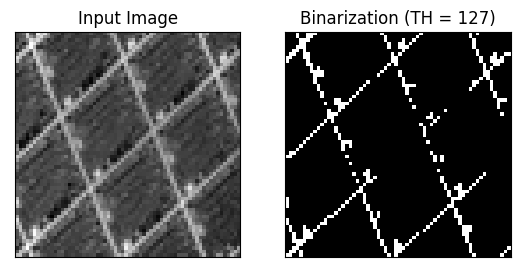

In [26]:
import matplotlib.pyplot as plt

plt.subplot(121),plt.imshow(input_image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(wafer_bin_test, cmap = 'gray')
plt.title('Binarization (TH = 127)'), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5, 1.0, 'Binarization + Dilation'), ([], []), ([], []))

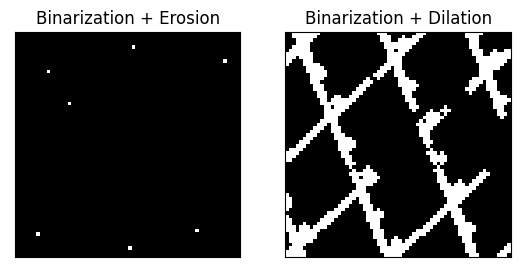

In [28]:
plt.subplot(121),plt.imshow(wafer_bin_erosion_test, cmap = 'gray')
plt.title('Binarization + Erosion'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(wafer_bin_dilation_test, cmap = 'gray')
plt.title('Binarization + Dilation'), plt.xticks([]), plt.yticks([])

### Dilation then erosion

In [ ]:
dilation_padded = np.pad(wafer_bin_dilation_test, ((1,1),(1,1)))

encoded_b2 = ""
for i in dilation_padded:
    for j, el in enumerate(i):
        encoded_b2 += format(el, '08b')

encoded_b2 = '\n'.join(encoded_b2[i:i+8] for i in range(0, len(encoded_b2), 8))

In [ ]:
with open('VHDL/images_in_fpga/src/wafer_dilated.mif', 'w')  as outfile:   
    outfile.write(encoded_b2)

In [36]:
wafer_dilation_erosion_test = np.uint8(np.zeros(shape=shape))

img_file = open('VHDL/images_in_fpga/wafer_dilated_and_eroded.txt', 'r')

for i in range(shape[0]):
    for j in range(shape[1]):
        line = img_file.readline()
        if not line:
            break
        wafer_dilation_erosion_test[i][j] = int(line.strip(), 2)

#wafer_bin_dilation_img = Image.fromarray(wafer_bin_dilation_test, 'L')

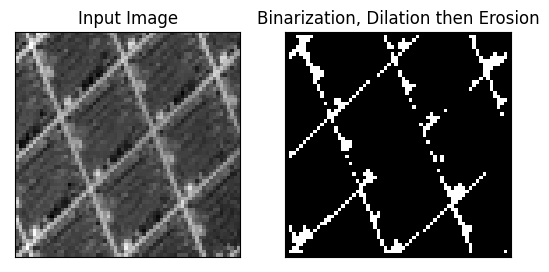

In [37]:
plt.subplot(121),plt.imshow(input_image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(wafer_dilation_erosion_test, cmap = 'gray')
plt.title('Binarization, Dilation then Erosion'), plt.xticks([]), plt.yticks([])
plt.show()

## Hough transform (Full pipeline)

### .mif creation

In [51]:
path = 'imgs/testwafer_2_gray.png'
input_image = Image.open(path).convert('L')
input_image = np.asarray(input_image)
shape = np.shape(input_image)
padded_image = np.pad(input_image, ((2,2),(2,2)))

encoded_b2 = ""
for i in padded_image:
    for j, el in enumerate(i):
        encoded_b2 += format(el, '08b')

encoded_b2 = '\n'.join(encoded_b2[i:i+8] for i in range(0, len(encoded_b2), 8))

with open('VHDL/images_in_fpga/src/wafer_gray.mif', 'w')  as outfile:   
    outfile.write(encoded_b2)

### Open FPGA output

In [69]:
fpga_out = np.uint8(np.zeros(shape=shape))

img_file = open('VHDL/images_in_fpga/fpga_output.txt', 'r')

for i in range(shape[0]):
    for j in range(shape[1]):
        line = img_file.readline()
        if not line:
            break
        fpga_out[i][j] = int(line.strip(), 2)

In [70]:
import cv2
from skimage.transform import hough_line, hough_line_peaks
from functions import *

Angulo: -103.57542°
Angulo: -14.07821°
Angulo: -14.07821°
Angulo: -103.57542°


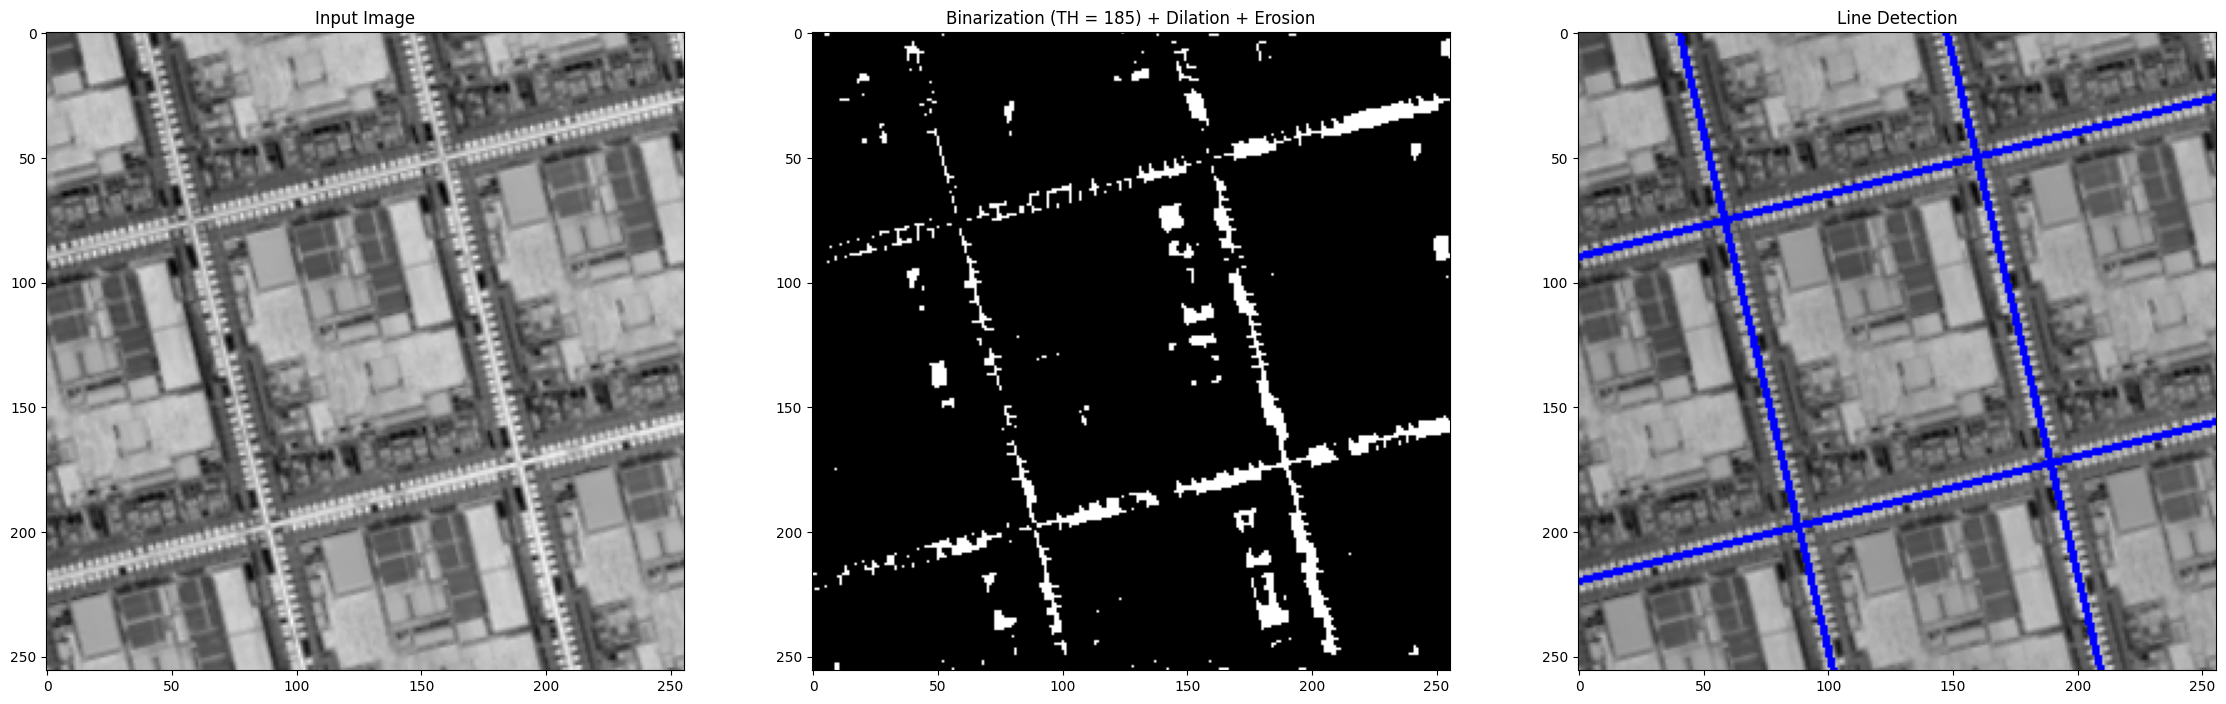

In [71]:
# Hough transform and lines drawing
# ---------------------------------
tested_angles = np.linspace(-np.pi/2,np.pi/2,180)
hspace, theta, dist = hough_line(fpga_out, tested_angles)
h, q, d = hough_line_peaks(hspace, theta, dist)


angle_list=[]  #Create an empty list to capture all angles

origin = np.array((0, fpga_out.shape[1]))

wafer_lines = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)

for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist)):
    angle_list.append(angle) #Not for plotting but later calculation of angles
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    texto = f'Angulo: {np.round((angle*180/np.pi)-90,5)}°'
    print(texto)
    cv2.line(wafer_lines,(origin[0],int(y0)),(origin[1],int(y1)),(0,0,255),2)

images = {'Input Image':input_image,
          'Binarization (TH = 185) + Dilation + Erosion':fpga_out,
          'Line Detection':wafer_lines
        }

compare(images, size=(28,20))